In [1]:
# fusing Google Drive

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?
W: chmod 0700 of directory /var/lib/apt/lists/partial failed - SetupAPTPartialDirectory (1: Operation not permitted)
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


ModuleNotFoundError: No module named 'google.colab'

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [8]:
cd drive/esca_hackathon/

/content/drive/esca_hackathon


In [6]:
!export PATH=/home/ondrej.palkoci/anaconda3/bin:$PATH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from seaborn import heatmap
import pandas as pd
import keras

/home/ondrej.palkoci/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os, cv2
from skimage.io import imread, imshow
from skimage.transform import rescale

def read_images(path, output_sz=(224, 224), ending='.JPG'):
    print('Reading from', path)
    files = [file for file in os.listdir(path) if file.endswith(ending)]
    image = imread(path+files[0])
    images = np.zeros(shape=(len(files), output_sz[0], output_sz[1], image.shape[2]))
    for i in range(len(files)):
        image = imread(path+files[i])
        # images[i,:,:,:] = rescale(image, 1/downsample, multichannel=True)
        images[i,:,:,:] = cv2.resize(image, dsize=output_sz, interpolation=cv2.INTER_AREA)
    print('Original resolution:', image.shape)
    print('New resolution:', images[0].shape)
    return images

# zdrave = read_images(path='zdrave/')
# esca = read_images(path='esca/')
# suche = read_images(path='suche/')
# zdrave_zber = read_images(path='zdrave_zber/')
# esca_koniec = read_images(path='train_esca_zber/')

In [9]:
cv2.imread('keras_folders1/test/healthy/image_test1.png').shape

(224, 224, 3)

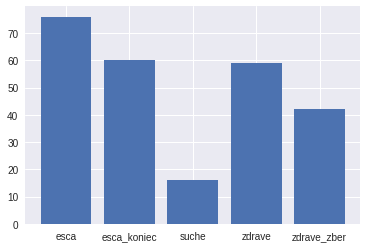

In [10]:
%matplotlib inline
plt.figure(0)
plt.bar(['zdrave', 'esca', 'suche', 'zdrave_zber', 'esca_koniec'],\
        [zdrave.shape[0], esca.shape[0], suche.shape[0], zdrave_zber.shape[0], esca_koniec.shape[0]])
plt.show()

In [0]:
train_ratio = 0.8

main_folder = 'keras_folders2'

# !rm -r main_folder
os.mkdir(main_folder)
os.mkdir(main_folder+'/train')
os.mkdir(main_folder+'/test')
os.mkdir(main_folder+'/train/healthy')
os.mkdir(main_folder+'/train/esca')
os.mkdir(main_folder+'/train/dry')
os.mkdir(main_folder+'/train/esca_koniec')
os.mkdir(main_folder+'/test/healthy')
os.mkdir(main_folder+'/test/esca')
os.mkdir(main_folder+'/test/dry')
os.mkdir(main_folder+'/test/esca_koniec')

zdrave_merged = np.concatenate((zdrave, zdrave_zber), axis=0)
# esca_merged = np.concatenate((esca, esca_koniec), axis=0)

def create_keras_folders(images, label, train_ratio=0.8):
    images_rnd = images[np.random.permutation(len(images))]

    train_set = images_rnd[:int(0.8*len(images_rnd))]
    test_set = images_rnd[int(0.8*len(images_rnd)):]

    for i in range(len(train_set)):
        print(main_folder+'/train/'+str(label)+'/image_train'+str(i)+'.png')
        cv2.imwrite(main_folder+'/train/'+str(label)+'/image_train'+str(i)+'.png', train_set[i])
        

    for i in range(len(test_set)):
        print(main_folder+'/test/'+str(label)+'/image_test'+str(i)+'.png')
        cv2.imwrite(main_folder+'/test/'+str(label)+'/image_test'+str(i)+'.png', test_set[i])

create_keras_folders(zdrave_merged, label='healthy')
create_keras_folders(esca, label='esca')
create_keras_folders(suche, label='dry')
create_keras_folders(esca_koniec, label='esca_koniec')


In [75]:
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Dense
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.applications.nasnet import NASNetMobile
from keras.applications.resnet50 import ResNet50

# base_model = MobileNet(include_top=False, alpha=1.0, dropout=1e-3, weights='imagenet', input_shape=(224,224,3))
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
# base_model = NASNetMobile(include_top=False, weights=None, input_shape=(224,224,3))
# base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=(224,224,3))
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

model = Sequential()
 
# Add the convolutional base model
model.add(base_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_15 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 3075      
Total params: 45,718,595
Trainable params: 45,718,595
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Freeze the layers except the last 2 layers
for layer in model.layers[:-2]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.training.Model object at 0x7fd8a9a9c320> False
<keras.layers.core.Flatten object at 0x7fd8a9d16e10> False
<keras.layers.core.Dense object at 0x7fd8a9a86e80> True
<keras.layers.core.Dense object at 0x7fd8a99686a0> True


In [77]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

# train_batchsize = 100
# val_batchsize = 10

train_generator = train_datagen.flow_from_directory('keras_folders3/keras_folders3/train',
        target_size=(224, 224),
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory('keras_folders3/keras_folders3/test',
        target_size=(224, 224),
        class_mode='categorical', shuffle=False)

Found 200 images belonging to 3 classes.
Found 53 images belonging to 3 classes.


In [78]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=5e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1, callbacks=[checkpoint])

Epoch 1/100
7/6 [=================================] - 22s 3s/step - loss: 5.0492 - acc: 0.5733 - val_loss: 1.9053 - val_acc: 0.7547

Epoch 00001: val_loss improved from inf to 1.90527, saving model to model-001.h5
Epoch 2/100
7/6 [=================================] - 1s 125ms/step - loss: 1.8912 - acc: 0.8316 - val_loss: 3.4940 - val_acc: 0.6604

Epoch 00002: val_loss did not improve from 1.90527
Epoch 3/100
7/6 [=================================] - 1s 122ms/step - loss: 1.0849 - acc: 0.9094 - val_loss: 1.5828 - val_acc: 0.8302

Epoch 00003: val_loss improved from 1.90527 to 1.58283, saving model to model-003.h5
Epoch 4/100
7/6 [=================================] - 1s 123ms/step - loss: 1.1822 - acc: 0.9267 - val_loss: 2.0227 - val_acc: 0.8113

Epoch 00004: val_loss did not improve from 1.58283
Epoch 5/100
7/6 [=================================] - 1s 124ms/step - loss: 0.7305 - acc: 0.9547 - val_loss: 1.9431 - val_acc: 0.8113

Epoch 00005: val_loss did not improve from 1.58283
Epoch 6/


Epoch 00044: val_loss did not improve from 1.58283
Epoch 45/100
7/6 [=================================] - 1s 123ms/step - loss: 0.9192 - acc: 0.9430 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00045: val_loss did not improve from 1.58283
Epoch 46/100
7/6 [=================================] - 1s 122ms/step - loss: 0.9192 - acc: 0.9430 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00046: val_loss did not improve from 1.58283
Epoch 47/100
7/6 [=================================] - 1s 125ms/step - loss: 0.7304 - acc: 0.9547 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00047: val_loss did not improve from 1.58283
Epoch 48/100
7/6 [=================================] - 1s 125ms/step - loss: 0.7304 - acc: 0.9547 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00048: val_loss did not improve from 1.58283
Epoch 49/100
7/6 [=================================] - 1s 123ms/step - loss: 0.7304 - acc: 0.9547 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00049: val_loss did not improve from 1.58283
Epoch 50/100



Epoch 00088: val_loss did not improve from 1.58283
Epoch 89/100
7/6 [=================================] - 1s 123ms/step - loss: 0.7304 - acc: 0.9547 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00089: val_loss did not improve from 1.58283
Epoch 90/100
7/6 [=================================] - 1s 124ms/step - loss: 0.9192 - acc: 0.9430 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00090: val_loss did not improve from 1.58283
Epoch 91/100
7/6 [=================================] - 1s 122ms/step - loss: 0.7304 - acc: 0.9547 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00091: val_loss did not improve from 1.58283
Epoch 92/100
7/6 [=================================] - 1s 125ms/step - loss: 0.9192 - acc: 0.9430 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00092: val_loss did not improve from 1.58283
Epoch 93/100
7/6 [=================================] - 1s 124ms/step - loss: 0.7304 - acc: 0.9547 - val_loss: 1.7048 - val_acc: 0.8302

Epoch 00093: val_loss did not improve from 1.58283
Epoch 94/100


In [79]:
for layer in model.layers:
    print(layer, layer.trainable)


<keras.engine.training.Model object at 0x7fd8a9a9c320> False
<keras.layers.core.Flatten object at 0x7fd8a9d16e10> False
<keras.layers.core.Dense object at 0x7fd8a9a86e80> True
<keras.layers.core.Dense object at 0x7fd8a99686a0> True


In [80]:

# images = [file for file in os.listdir('keras_folders1/val')]
val_images = read_images(path='keras_folders1/val/', ending='png')

model.predict_classes(val_images)

NameError: name 'read_images' is not defined

In [0]:
# model.save('mobile_net_2_classes.h5')


In [65]:
!cp -r keras_folders2 keras_folders3

In [4]:
import zipfile
with zipfile.ZipFile("suche.zip","r") as zip_ref:
    zip_ref.extractall("suche")

In [82]:
from keras.models import load_model
model4 = load_model('VGG19_79_4_classes.h5')
# model.predict_classes(val_images)

/home/ondrej.palkoci/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [7]:
from keras.models import load_model

model3 = load_model('VGG19_83_3classes.h5')
# model.predict_classes(val_images)

/home/ondrej.palkoci/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
suche = read_images(path='suche/suche/', ending='PNG')

Reading from suche/suche/
Original resolution: (224, 224, 3)
New resolution: (224, 224, 3)


In [14]:
healthy = read_images(path='healthy/healthy/', ending='PNG')

Reading from healthy/healthy/
Original resolution: (224, 224, 3)
New resolution: (224, 224, 3)
